In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from arch import arch_model
from arch.univariate import ConstantMean
import mgarch

In [2]:
Bank_data = pd.read_csv("Bank_data_full_2.csv")
Bank_data = Bank_data.drop(['PERMNO','PERMCO'], axis = 1)

Bank_data_other = pd.read_csv("Bank_data_full_2.csv")
Bank_data_other = Bank_data_other.drop(['PERMNO','PERMCO'], axis = 1)



SP_index = pd.read_csv("SP_500_Data.csv")
sector_data = pd.read_csv("48_Industry_Portfolios_Daily.csv")
sector_data = sector_data.rename(columns={sector_data.columns[0]:'Date'})
sector_data.head()

sector_data.iloc[:, 0] = pd.to_datetime(sector_data.iloc[:, 0].astype(str), format='%Y%m%d', errors='coerce')

sector_data = sector_data[['Date','Aero', 'Guns', 'Ships','Oil', 'Coal', 'Util']].copy()

sector_data = sector_data.loc[:26132]




/var/folders/0q/vd9_j4p16sxdmvrf02mwf33m0000gn/T/ipykernel_40676/2074775263.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  Bank_data = pd.read_csv("Bank_data_full_2.csv")
/var/folders/0q/vd9_j4p16sxdmvrf02mwf33m0000gn/T/ipykernel_40676/2074775263.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  Bank_data_other = pd.read_csv("Bank_data_full_2.csv")
/var/folders/0q/vd9_j4p16sxdmvrf02mwf33m0000gn/T/ipykernel_40676/2074775263.py:10: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  sector_data = pd.read_csv("48_Industry_Portfolios_Daily.csv")


In [3]:
Bank_data_other['Market_Cap'] = Bank_data_other['PRC'].values*Bank_data_other['SHROUT'].values


In [4]:
sector_data.set_index('Date', inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexes/base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [5]:
sector_data = sector_data.sort_index()
sector_data = sector_data[ (sector_data.index >= '2000-01-03') & (sector_data.index <= '2009-12-31') ].copy()


In [6]:

SP_index = SP_index.rename(columns={'caldt':'Date','sprtrn': 'Ret'})

SP_index.set_index('Date', inplace=True)

In [7]:
SP_index = SP_index.sort_index()

SP_index = SP_index[ (SP_index.index >= '2000-01-03') & (SP_index.index <= '2009-12-31') ].copy()

In [8]:
sector_data = sector_data.apply(pd.to_numeric, errors='coerce')

In [9]:
Defence_index = pd.DataFrame()
Energy_index = pd.DataFrame()

Defence_index = 1/3*sector_data['Aero'].values+1/3*sector_data['Guns'].values+1/3*sector_data['Ships'].values
Energy_index = 1/3*sector_data['Oil'].values+1/3*sector_data['Coal'].values+1/3*sector_data['Util'].values

In [10]:
Defence_index  = pd.DataFrame(Defence_index, index = sector_data.index)

Energy_index = pd.DataFrame(Energy_index,index=sector_data.index)

Defence_index = Defence_index
Energy_index = Energy_index
Energy_index.head()

,0
Date,
2000-01-03,-0.773333
2000-01-04,-2.586667
2000-01-05,1.183333
2000-01-06,0.460000
2000-01-07,1.623333


In [11]:
SP_index.columns

Index(['Ret'], dtype='object')

In [12]:
Geo_Pol_long = pd.DataFrame()
Geo_Pol_short = pd.DataFrame()
Geo_Pol_index = pd.DataFrame()

Geo_Pol_long = 0.5*Defence_index.values+0.5*Energy_index.values
Geo_Pol_long = pd.DataFrame(Geo_Pol_long, index = Energy_index.index)

Geo_Pol_short = -SP_index.values


In [13]:
Geo_Pol_index = Geo_Pol_long+Geo_Pol_short


In [14]:
Bank_data['date'] = pd.to_datetime(Bank_data['date'])
Bank_data.set_index('date', inplace=True)

In [15]:
Bank_data_other['date'] = pd.to_datetime(Bank_data_other['date'])
Bank_data_other.set_index('date', inplace=True)

In [16]:
Bank_data= Bank_data.sort_index()

Bank_data = Bank_data[ (Bank_data.index >= '2000-01-03') & (Bank_data.index <= '2009-12-31') ].copy()

In [17]:
Bank_data_other = Bank_data_other.sort_index()

Bank_data_other = Bank_data_other[ (Bank_data_other.index >= '2000-01-03') & (Bank_data_other.index <= '2009-12-31') ].copy()

In [18]:

Bank_data = {ticker: group for ticker, group in Bank_data.groupby('TICKER')}

In [19]:

Bank_data_other = {ticker: group for ticker, group in Bank_data_other.groupby('TICKER')}


In [20]:
X = np.column_stack([SP_index.values, Geo_Pol_index.values])
X = sm.add_constant(X)


results = {}




In [21]:
for ticker,y in Bank_data.items():

    if len(y)==len(SP_index):

        ys = y['RET'].astype(float).values
        X_ = X.astype(float)
        model = sm.OLS(ys, X).fit()
        results[ticker] = model





In [22]:
market_caps = [np.mean(y['Market_Cap']) for y in Bank_data_other.values()]
threshold = np.percentile(market_caps, 90)
print("Market Cap threshold for top 10% banks:", threshold)

Market Cap threshold for top 10% banks: 3968542.461810585


In [23]:
results_other = {}
for ticker,y in Bank_data_other.items():


    if len(y)==len(SP_index)and np.mean(y['Market_Cap'])>threshold:

        ys = y['RET'].astype(float).values
        X_ = X.astype(float)
        model = sm.OLS(ys, X).fit()
        results_other[ticker] = model





In [24]:
neg_x2 = {}

x2_idx = 2
for ticker, model in results.items():

    x2_coef = model.params[x2_idx]
    x2_tval = model.tvalues[x2_idx]

    if x2_coef < 0 and np.abs(x2_tval) > 2 :
        neg_x2[ticker] = {
            'x2_coef': x2_coef,
            'x2_tvalue': x2_tval,
            'results': model.summary()
        }

for ticker, vals in neg_x2.items():
    print(ticker, vals['x2_coef'], vals['x2_tvalue'],'\n', vals['results'])

ASBC -0.0017278480051465392 -4.027762290308644 
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     917.3
Date:                Wed, 14 Jan 2026   Prob (F-statistic):          8.10e-300
Time:                        19:04:18   Log-Likelihood:                 6421.9
No. Observations:                2515   AIC:                        -1.284e+04
Df Residuals:                    2512   BIC:                        -1.282e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

In [25]:
neg_x2_other = {}

for ticker, model in results_other.items():

    x2_coef = model.params[x2_idx]
    x2_tval = model.tvalues[x2_idx]

    if x2_coef < 0 and np.abs(x2_tval) > 2 :
        neg_x2_other[ticker] = {
            'x2_coef': x2_coef,
            'x2_tvalue': x2_tval
        }

for ticker, vals in neg_x2_other.items():
    print(ticker, vals['x2_coef'], vals['x2_tvalue'])

AXP -0.002003860108572527 -4.9385855714608295
BAC -0.002309599241487782 -3.7782244397908102
BBT -0.0020075566024499105 -4.677709263390665
BK -0.0018009422008917093 -3.885234508830512
COF -0.002500325016342699 -3.885169641358104
MI -0.002021852352599582 -3.1103957213448616
MTB -0.0016210196193671546 -4.014889837691752
NTRS -0.002022217990977242 -4.895078166847998
SNV -0.0025017350581820765 -3.9107687255606285
STI -0.003737458772600071 -6.384796789373679
USB -0.002759690095552564 -5.835784910979867
WFC -0.0019081370057442105 -3.5908042419674397


# Prepare Exog neg returns Indicator 

In [26]:
r_minus = [i if i < 0 else 0 for i in SP_index['Ret']]


In [27]:
len(r_minus)

2515

# Prepare log returns + scaling

In [28]:
# data prep 

for ticker ,y in Bank_data.items():
    y['RET'] = pd.to_numeric(y['RET'], errors='coerce')
    y['RET'] = y['RET'].interpolate(method='linear', limit=2) 
    y['RET'] = y['RET'].fillna(0.0)
    y['logRET'] = np.log1p(1 + (y['RET'].copy()).astype(float).values)
    y['logRET'] = y['logRET']*100
    Bank_data[ticker]['logRET'] = y['logRET']

# GJR-GARCH

In [29]:
x = r_minus.copy()*100
x = sm.add_constant(x)

sigma_i = {}
res_i = {} 
z_i = {}

for ticker,y in Bank_data.items():
    if len(y)==len(r_minus):
        ys = y['logRET'].values
        model_i = arch_model(ys,x, vol='Garch', p=1, q=1)
        res_i[ticker] = model_i.fit(disp='off')
        sigma_i[ticker] = res_i[ticker].conditional_volatility
        z_i[ticker] = res_i[ticker].resid / sigma_i[ticker]
        
rm = SP_index['Ret'].values
model_m = arch_model(rm,x, vol='Garch', p=1, q=1)
res_m = model_m.fit(disp='off')
sigma_m = res_m.conditional_volatility
z_m = res_m.resid / sigma_m

fgeo = Geo_Pol_index.values
model_geo = arch_model(fgeo,x, vol='Garch', p=1, q=1)
res_geo = model_geo.fit(disp='off')
sigma_geo = res_geo.conditional_volatility
z_geo = res_geo.resid / sigma_geo




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000196. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


# DCC 

In [30]:
def extract_R_t(model):
    a = model.a
    b = model.b
    D_t = model.D_t  # T x N conditional volatilities
    rt = model.rt    # T x N returns (mean-centered)
    T = rt.shape[0]
    N = rt.shape[1]
    
    Q_bar = np.cov(rt.T)  # Long-run correlation
    Q_t = np.zeros((T, N, N))
    R_t = np.zeros((T, N, N))
    
    Q_t[0] = np.matmul(rt[0].T / 2, rt[0] / 2)
    
    for i in range(1, T):
        dts = np.diag(D_t[i])
        dtinv = np.linalg.inv(dts)
        et = dtinv @ rt[i].T  # Standardized residuals
        
        Q_t[i] = (1 - a - b) * Q_bar + a * (et * et.T) + b * Q_t[i - 1]
        qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))
        
        R_t[i] = qts @ Q_t[i] @ qts  # Normalized correlation
    
    return R_t  # T x N x N array of correlation matrices

In [31]:
if 'BAC' in z_i.keys():
    print(True)

True


In [32]:
R_t_dict = {}
# for ticker in z_i.keys():
ticker = 'BAC'
z_stack = np.column_stack([z_i[ticker], z_m, z_geo])
mgarch_model = mgarch.mgarch()
mgarch_model.fit(returns=z_stack)
R_t = extract_R_t(mgarch_model)
R_t_dict[ticker] = R_t

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mgarch/mgarch.py:65: RuntimeWarning: invalid value encountered in log
  np.log(np.linalg.det(R_t[i])) + \
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mgarch/mgarch.py:56: RuntimeWarning: invalid value encountered in sqrt
  qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [33]:
len(R_t)

2515

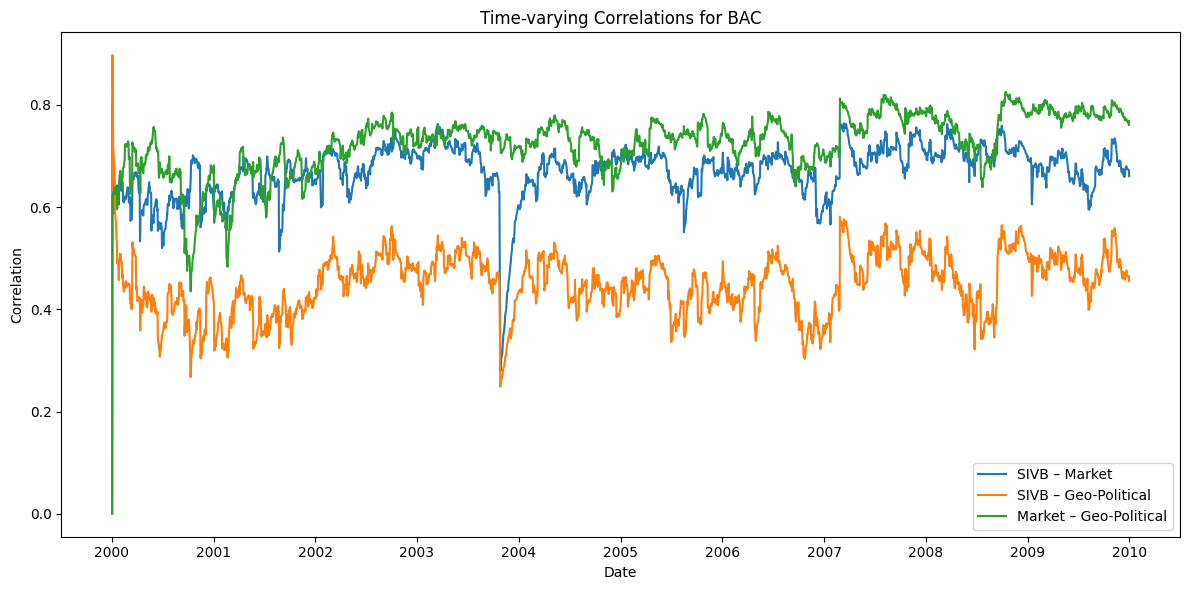

In [34]:
import matplotlib.pyplot as plt

ticker = 'BAC'
R_t = R_t_dict[ticker]

# Assume returns_df was used to compute R_t
dates = y.index  # ← exact trading days used

plt.figure(figsize=(12, 6))

plt.plot(dates, R_t[:, 0, 1], label='SIVB – Market')
plt.plot(dates, R_t[:, 0, 2], label='SIVB – Geo-Political')
plt.plot(dates, R_t[:, 1, 2], label='Market – Geo-Political')

plt.title(f'Time-varying Correlations for {ticker}')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
beta_t = {}
R = R_t_dict['BAC']
rho_im = R[:, 0, 1]
rho_ig = R[:, 0, 2]
rho_mg = R[:, 1, 2]

T = R.shape[0]

Sigma_FF = np.zeros((T, 2, 2))
Sigma_FF[:, 0, 0] = sigma_m**2
Sigma_FF[:, 1, 1] = sigma_geo**2
Sigma_FF[:, 0, 1] = rho_mg * sigma_m * sigma_geo
Sigma_FF[:, 1, 0] = rho_mg * sigma_m * sigma_geo

Sigma_iF = np.zeros((T, 2, 1))
Sigma_iF[:, 0, 0] = rho_im * sigma_i['BAC'] * sigma_m
Sigma_iF[:, 1, 0] = rho_ig * sigma_i['BAC'] * sigma_geo


Sigma_FF_inv = np.linalg.inv(Sigma_FF)  # (T, 2, 2)

beta_t['BAC'] = np.matmul(Sigma_FF_inv, Sigma_iF)  # (T, 2, 1)


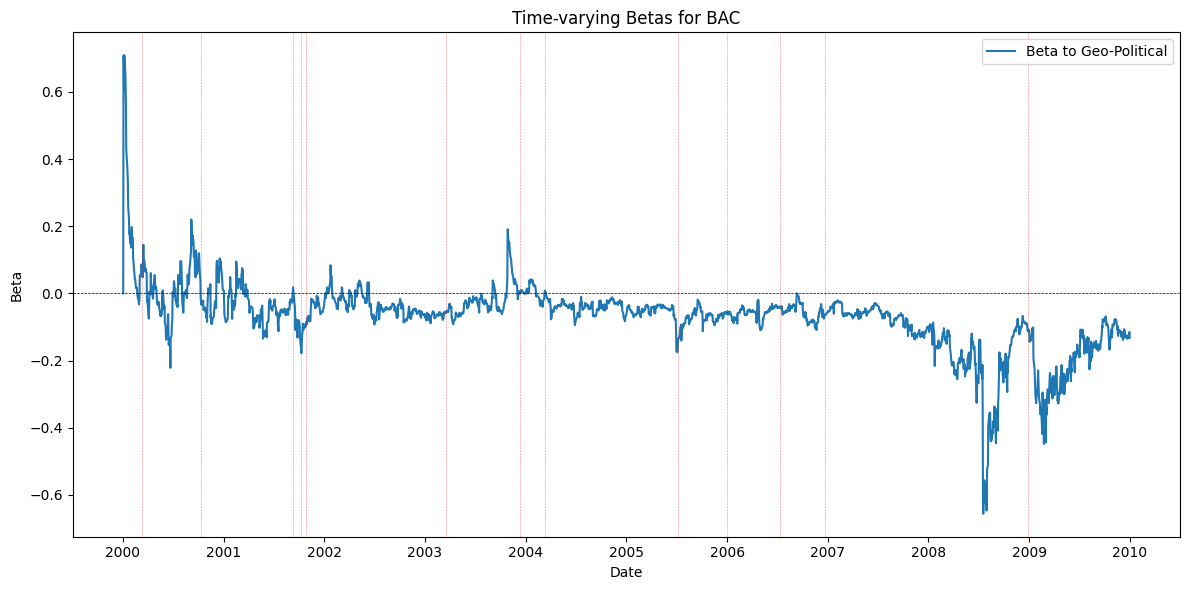

In [ ]:
events = {
    # --- Early 2000s ---
    'USS Cole Bombing': pd.Timestamp('2000-10-12'),

    # --- 9/11 and War on Terror ---
    '9/11 Attacks': pd.Timestamp('2001-09-11'),
    'Afghanistan War Begins': pd.Timestamp('2001-10-07'),
    'Patriot Act Signed': pd.Timestamp('2001-10-26'),

    # --- Middle East conflicts ---
    'Iraq Invasion': pd.Timestamp('2003-03-20'),
    'Capture of Saddam Hussein': pd.Timestamp('2003-12-13'),
    'Madrid Train Bombings': pd.Timestamp('2004-03-11'),

    # --- Terrorism in financial centers ---
    'London Bombings': pd.Timestamp('2005-07-07'),

    # --- Energy & geopolitical tension ---
    'Russia–Ukraine Gas Dispute': pd.Timestamp('2006-01-01'),
    'Israel–Hezbollah War': pd.Timestamp('2006-07-12'),
    'Iran Nuclear Sanctions Escalation': pd.Timestamp('2006-12-23'),

    # --- Late period ---
    'Gaza War Begins': pd.Timestamp('2008-12-27')
}


plt.figure(figsize=(12, 6))
plt.plot(dates, beta_t['BAC'][:, 1, 0], label='Beta to Geo-Political')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
for event, date in events.items():
    plt.axvline(x=date, color='red', linestyle='--', linewidth=0.4, alpha=0.5)
plt.title('Time-varying Betas for BAC')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()
plt.tight_layout()
plt.show()